# Exploratory Data Analysis

## Collect data out of MongoDB and Chroma DB

In [2]:
import os
import pymongo
import pandas as pd
from dotenv import load_dotenv
import chromadb

load_dotenv()

True

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
client = pymongo.MongoClient(os.getenv('MONGO_CONNECTION_STRING'))
db = client["monin"]
collection = db["drinks"]

In [5]:
collection.find({})[0]

{'_id': ObjectId('67cdeca2d61baaa7449cc9f0'),
 'name': 'Hawaiian Pearl Bubble Tea',
 'recipie': ['30 mL Monin Hawaiian Island Syrup',
  '150 mL tea',
  '60 mL club soda',
  '45 mL tapioca bobas',
  'Fill serving glass full of ice.',
  'Pour ingredients into serving glass in order listed.',
  'Stir gently to mix.',
  'Add garnish and serve.'],
 'category': 'bubble_teas',
 'image_url': 'https://monin.blob.core.windows.net/recipe/images/mrd/drink/5125b732-6dea-4287-a76e-fdb0588dc394-2.png',
 'drink_url': 'https://monin.us/products/hawaiian-pearl-bubble-tea',
 'taste': ['Citrusy', 'Sour']}

In [6]:
collection.count_documents({})

2004

In [7]:
chroma_client_remote = chromadb.HttpClient(host=os.environ.get('CHROMA_URL'), port=8000,
                         settings=chromadb.config.Settings(
                            chroma_client_auth_provider="chromadb.auth.token_authn.TokenAuthClientProvider", 
                            chroma_client_auth_credentials=os.environ.get('CHROMA_TOKEN')
                         ))

collection_text = chroma_client_remote.get_or_create_collection(name="drinks_text")
collection_image = chroma_client_remote.get_or_create_collection(name="drinks_image")
collection_combined = chroma_client_remote.get_or_create_collection(name="drinks_combined")

local_text_data = collection_text.get(include=["embeddings", "uris", "documents", "metadatas"])
local_image_data = collection_image.get(include=["embeddings", "uris", "documents", "metadatas"])
local_combined_data = collection_combined.get(include=["embeddings", "uris", "documents", "metadatas"])



In [8]:
print(len(local_text_data['ids']))
print(len(local_image_data['ids']))
print(len(local_combined_data['ids']))

2004
2004
2004


In [9]:
# print json structure
print(local_text_data['ids'][0])
print(local_text_data['embeddings'][0][:10])

67cdeca2d61baaa7449cc9f0
[-0.24252538 -0.03239031 -0.03322265 -0.16887261 -0.13254963 -0.12070928
 -0.21278407 -1.1255417  -0.19371681  0.07274342]


In [10]:
data = list(collection.find({}))
df = pd.DataFrame(data)

# If available, load your embeddings from chromadb (assuming they match the same order as your df)
# For example, after retrieving the embeddings:
df['text_embeds'] = list(local_text_data['embeddings'])
df['image_embeds'] = list(local_image_data['embeddings'])

In [11]:
df['combined_embeds'] = list(local_combined_data['embeddings'])

In [12]:
df.head()

,_id,name,recipie,category,image_url,drink_url,taste,text_embeds,image_embeds,combined_embeds
0,67cdeca2d61baaa7449cc9f0,Hawaiian Pearl Bubble Tea,"[30 mL Monin Hawaiian Island Syrup, 150 mL tea...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/hawaiian-pearl-bubbl...,"[Citrusy, Sour]","[-0.24252538, -0.03239031, -0.033222646, -0.16...","[-0.27175665, 0.78657407, -0.12571463, 0.28179...","[-0.24252538, -0.03239031, -0.033222646, -0.16..."
1,67cdeca4d61baaa7449cc9f1,Blue Bubble Milk Tea,"[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/blue-bubble-milk-tea,"[Floral, Salty, Sweet]","[-0.14095394, -0.083773464, 0.11836207, 0.1184...","[0.13253294, 0.3377095, -0.1990263, 0.43868613...","[-0.14095394, -0.083773464, 0.11836207, 0.1184..."
2,67cdeca6d61baaa7449cc9f2,Strawberry Bubble Burst Tea,"[30 mL Monin Strawberry Purée, 15 mL fresh lem...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/strawberry-bubble-bu...,"[Fruity, Floral, Sweet, Bitter]","[-0.15835342, 0.0019426532, 0.3578596, -0.0975...","[-0.2511133, 0.81496274, -0.2903915, -0.023840...","[-0.15835342, 0.0019426532, 0.3578596, -0.0975..."
3,67cdeca8d61baaa7449cc9f3,Bubble Chai Tea,"[30 mL Monin Chai Tea Concentrate, 210 mL milk...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/bubble-chai-tea,"[Sweet, Creamy]","[-0.12927054, -0.08475506, 0.08285433, 0.07675...","[0.051974114, 0.3284219, -0.1577228, 0.3664531...","[-0.12927054, -0.08475506, 0.08285433, 0.07675..."
4,67cdecabd61baaa7449cc9f4,Golden Jelly Bubble Tea,"[30 mL Monin Golden Turmeric Syrup, 120 mL bla...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/golden-jelly-bubble-tea,"[Floral, Salty, Bitter, Floral]","[-0.21029785, -0.07430075, 0.36528605, 0.13653...","[-0.3368239, 0.99112916, -0.21998006, 0.319091...","[-0.21029785, -0.07430075, 0.36528605, 0.13653..."


## Check missing values and data types

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   _id              2004 non-null   object
 1   name             2004 non-null   object
 2   recipie          2004 non-null   object
 3   category         2004 non-null   object
 4   image_url        2004 non-null   object
 5   drink_url        2004 non-null   object
 6   taste            2004 non-null   object
 7   text_embeds      2004 non-null   object
 8   image_embeds     2004 non-null   object
 9   combined_embeds  2004 non-null   object
dtypes: object(10)
memory usage: 156.7+ KB


In [14]:
df.applymap(type).applymap(lambda x: x.__name__).T

,0,1,2,3,4,5,6,7,8,9,...,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003
_id,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,...,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId,ObjectId
name,str,str,str,str,str,str,str,str,str,str,...,str,str,str,str,str,str,str,str,str,str
recipie,list,list,list,list,list,list,list,list,list,list,...,list,list,list,list,list,list,list,list,list,list
category,str,str,str,str,str,str,str,str,str,str,...,str,str,str,str,str,str,str,str,str,str
image_url,str,str,str,str,str,str,str,str,str,str,...,str,str,str,str,str,str,str,str,str,str
drink_url,str,str,str,str,str,str,str,str,str,str,...,str,str,str,str,str,str,str,str,str,str
taste,list,list,list,list,list,list,list,list,list,list,...,list,list,list,list,list,list,list,list,list,list
text_embeds,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,...,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray
image_embeds,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,...,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray
combined_embeds,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,...,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray,ndarray


### Check consistency of data types in columns with composite objects.

In [15]:

df_consist = df.copy()
for col in ['recipie', 'taste', 'text_embeds', 'image_embeds', 'combined_embeds']:
    values = df_consist[col].apply(lambda x: [type(i) for i in x]).apply(set)
    print(f"Column: {col}")
    display(pd.DataFrame(values.tolist()).stack().value_counts())
    print()

Column: recipie


<class 'str'>    2004
Name: count, dtype: int64


Column: taste


<class 'str'>    2004
Name: count, dtype: int64


Column: text_embeds


<class 'numpy.float64'>    2004
Name: count, dtype: int64


Column: image_embeds


<class 'numpy.float64'>    2004
Name: count, dtype: int64


Column: combined_embeds


<class 'numpy.float64'>    2004
Name: count, dtype: int64

### Check for duplicates

In [16]:
df_tuple = df.copy()
for col in ['recipie', 'taste', 'text_embeds', 'image_embeds', 'combined_embeds']:
    df_tuple[col] = df_tuple[col].apply(lambda x: tuple(x) if isinstance(x, list) else x)

In [17]:
for col in df_tuple.columns:
    print(f"Column: {col}")
    print(f"Number of duplicates: {df_tuple.duplicated(subset=col).sum()}")
    print()
# check for duplicates in each column

Column: _id
Number of duplicates: 0

Column: name
Number of duplicates: 4

Column: recipie
Number of duplicates: 10

Column: category
Number of duplicates: 1992

Column: image_url
Number of duplicates: 1

Column: drink_url
Number of duplicates: 1

Column: taste
Number of duplicates: 990

Column: text_embeds
Number of duplicates: 0

Column: image_embeds
Number of duplicates: 0

Column: combined_embeds
Number of duplicates: 0



In [18]:
df_tuple[df_tuple.duplicated(subset=['recipie'], keep=False)].sort_values(by=['recipie'])

,_id,name,recipie,category,image_url,drink_url,taste,text_embeds,image_embeds,combined_embeds
1753,67ce0d10d61baaa7449cd0c9,Blueberry PurÉE Sangria,"(120 mL sweet white wine, 15 mL brandy, 15 mL ...",sangrias,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/blueberry-puree-sangria,"(Sweet, Sour, Bitter, Spicy)","[-0.17093089, -0.051256217, 0.11262131, -0.225...","[-0.24365298, 0.5808815, -0.098546, -0.2703004...","[-0.17093089, -0.051256217, 0.11262131, -0.225..."
1750,67ce0d04d61baaa7449cd0c6,Berry Blueberry Sangria,"(120 mL sweet white wine, 15 mL brandy, 15 mL ...",sangrias,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/berry-blueberry-sangria,"(Sweet, Sour, Fruity, Umami, Spicy, Creamy, Ci...","[-0.09985894, -0.052688062, 0.12471364, -0.123...","[-0.24365298, 0.5808815, -0.098546, -0.2703004...","[-0.09985894, -0.052688062, 0.12471364, -0.123..."
120,67cdedb2d61baaa7449cca68,Hot Caramel Apple Pie,"(15 mL Monin Caramel Apple Butter Syrup, 15 mL...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/hot-caramel-apple-pie,"(Citrusy, Rich, Spicy, Sweet)","[-0.09792483, -0.009621233, 0.11374956, -0.164...","[0.27019715, 0.9769207, 0.12613992, 0.41562706...","[-0.09792483, -0.009621233, 0.11374956, -0.164..."
495,67cdf15bd61baaa7449ccbdf,Caramel Apple Countdown Latte,"(15 mL Monin Caramel Apple Butter Syrup, 15 mL...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/caramel-apple-countd...,"(Sweet, Sour, Creamy, Umami)","[-0.10552476, 0.0006632954, -0.088973805, -0.0...","[0.27019715, 0.9769207, 0.12613992, 0.41562706...","[-0.10552476, 0.0006632954, -0.088973805, -0.0..."
632,67cdf4f6d61baaa7449ccc68,Coconut Mocha Delight,"(15 mL Monin Coconut Syrup, 15 mL Monin Dark C...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/coconut-mocha-delight,"(Spicy, Sour, Sweet, Floral)","[-0.072098985, -0.103037596, 0.15580605, -0.15...","[0.21257828, 1.0017374, 0.18046775, 0.23156838...","[-0.072098985, -0.103037596, 0.15580605, -0.15..."
180,67cdee39d61baaa7449ccaa4,Macaroon Mocha,"(15 mL Monin Coconut Syrup, 15 mL Monin Dark C...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/macaroon-mocha,"(Citrusy, Floral, Herbal, Sour, Spicy)","[-0.19018817, 0.06417283, 0.15528944, 0.047822...","[0.18786412, 1.0147005, 0.17624965, 0.20934093...","[-0.19018817, 0.06417283, 0.15528944, 0.047822..."
557,67cdf200d61baaa7449ccc1d,Peppermint White Mocha,"(15 mL Monin Peppermint Syrup, 30 mL Monin Whi...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/peppermint-white-mocha,"(Creamy, Floral, Sour)","[-0.16251682, -0.13105656, 0.2252307, -0.21728...","[-0.45004836, 0.7318835, 0.23708658, 0.2762295...","[-0.16251682, -0.13105656, 0.2252307, -0.21728..."
1511,67ce0811d61baaa7449ccfd7,Candy Cane Cocoa,"(15 mL Monin Peppermint Syrup, 30 mL Monin Whi...",cocoas_and_steamers,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/candy-cane-cocoa,"(Sweet, Sour, Bitter, Floral)","[-0.22224002, -0.0014989972, 0.26720592, 0.016...","[0.3439204, 0.7526773, 0.031720296, 0.45317832...","[-0.22224002, -0.0014989972, 0.26720592, 0.016..."
270,67cdef15d61baaa7449ccafe,Pumpkin Spice Latte,"(30 mL Monin Pumpkin Spice Syrup, 2 shot(s) es...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/pumpkin-spice-latte-1,"(Sweet, Sour, Umami)","[-0.21847993, -0.0030556023, -0.16042492, 0.01...","[0.30222645, 0.9132142, 0.05970951, 0.27662206...","[-0.21847993, -0.0030556023, -0.16042492, 0.01..."
671,67cdf5dad61baaa7449ccc8f,Pumpkin Spice Latte,"(30 mL Monin Pumpkin Spice Syrup, 2 shot(s) es...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/pumpkin-spice-latte,"(Floral, Citrusy, Sweet, Spicy)","[-0.11383813, -0.04879301, 0.14953282, -0.1797...","[0.288

In [19]:
df_tuple[df_tuple.duplicated(subset=['name'], keep=False)].sort_values(by=['name'])

,_id,name,recipie,category,image_url,drink_url,taste,text_embeds,image_embeds,combined_embeds
1208,67ce01c3d61baaa7449ccea8,Bloody Brain,"(45 mL premium vodka, 45 mL Monin Ginger Beer ...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/bloody-brain,"(Tart, Umami, Sweet, Fruity)","[-0.2261773, -0.0435815, 0.16115339, 0.0420805...","[-0.32230335, 0.45121166, -0.34248057, -0.2068...","[-0.2261773, -0.0435815, 0.16115339, 0.0420805..."
1967,67cea3e3dd42ba7f0305b0d8,Bloody Brain,"(30 mL Monin Blue Raspberry Syrup, 2 pump(s) M...",lemonade,https://gorecipe.monin.com/images/a9df4910-591...,https://monin.us/products/bloody-brain-1,"(Citrusy, Herbal, Sour, Tart, Floral)","[-0.08123554, -0.012689181, 0.20591506, 0.0943...","[-0.19110323, 0.3338697, -0.310462, 0.09035395...","[-0.08123554, -0.012689181, 0.20591506, 0.0943..."
270,67cdef15d61baaa7449ccafe,Pumpkin Spice Latte,"(30 mL Monin Pumpkin Spice Syrup, 2 shot(s) es...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/pumpkin-spice-latte-1,"(Sweet, Sour, Umami)","[-0.21847993, -0.0030556023, -0.16042492, 0.01...","[0.30222645, 0.9132142, 0.05970951, 0.27662206...","[-0.21847993, -0.0030556023, -0.16042492, 0.01..."
671,67cdf5dad61baaa7449ccc8f,Pumpkin Spice Latte,"(30 mL Monin Pumpkin Spice Syrup, 2 shot(s) es...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/pumpkin-spice-latte,"(Floral, Citrusy, Sweet, Spicy)","[-0.11383813, -0.04879301, 0.14953282, -0.1797...","[0.28876156, 0.9306724, 0.062710695, 0.2681756...","[-0.11383813, -0.04879301, 0.14953282, -0.1797..."
48,67cded09d61baaa7449cca20,Spooky Spiced Cider,"(ice, 22 1/2 mL Monin Spiced Brown Sugar Syrup...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/spooky-spiced-cider,"(Citrusy, Floral, Fruity, Sour)","[-0.090827264, -0.070087604, 0.24801469, -0.13...","[-0.21190381, 0.8053888, -0.22467107, 0.135612...","[-0.090827264, -0.070087604, 0.24801469, -0.13..."
178,67cdee35d61baaa7449ccaa2,Spooky Spiced Cider,"(ice, 22 1/2 mL Monin Spiced Brown Sugar Syrup...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/spooky-spiced-cider,"(Citrusy, Floral, Herbal)","[-0.13989773, 0.038824968, 0.16210036, 0.18462...","[-0.21190381, 0.8053888, -0.22467107, 0.135612...","[-0.13989773, 0.038824968, 0.16210036, 0.18462..."
1634,67ce0a96d61baaa7449cd052,Ube Latte,"(30 mL Monin Ube Syrup, 2 shot(s) espresso, Fi...",coffee,https://gorecipe.monin.com/images/fbc1f105-18a...,https://monin.us/products/ube-latte-1,"(Floral, Fruity, Salty, Sour)","[-0.10933075, -0.054580398, 0.14162602, -0.136...","[0.3641972, 0.9084685, 0.16578239, 0.35722536,...","[-0.10933075, -0.054580398, 0.14162602, -0.136..."
1641,67ce0abed61baaa7449cd059,Ube Latte,"(30 mL Monin Ube Syrup, 2 shot(s) espresso, Fi...",coffee,https://gorecipe.monin.com/images/a3e8c907-5ea...,https://monin.us/products/ube-latte,"(Umami, Spicy, Floral, Sweet)","[-0.1907921, -0.36480266, 0.23796397, 0.056157...","[0.17963903, 0.30783713, -0.085004956, -0.3564...","[-0.1907921, -0.36480266, 0.23796397, 0.056157..."


In [20]:
df_tuple[df_tuple.duplicated(subset=['name', 'recipie'], keep=False)].sort_values(by=['name', 'recipie'])

,_id,name,recipie,category,image_url,drink_url,taste,text_embeds,image_embeds,combined_embeds
270,67cdef15d61baaa7449ccafe,Pumpkin Spice Latte,"(30 mL Monin Pumpkin Spice Syrup, 2 shot(s) es...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/pumpkin-spice-latte-1,"(Sweet, Sour, Umami)","[-0.21847993, -0.0030556023, -0.16042492, 0.01...","[0.30222645, 0.9132142, 0.05970951, 0.27662206...","[-0.21847993, -0.0030556023, -0.16042492, 0.01..."
671,67cdf5dad61baaa7449ccc8f,Pumpkin Spice Latte,"(30 mL Monin Pumpkin Spice Syrup, 2 shot(s) es...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/pumpkin-spice-latte,"(Floral, Citrusy, Sweet, Spicy)","[-0.11383813, -0.04879301, 0.14953282, -0.1797...","[0.28876156, 0.9306724, 0.062710695, 0.2681756...","[-0.11383813, -0.04879301, 0.14953282, -0.1797..."
48,67cded09d61baaa7449cca20,Spooky Spiced Cider,"(ice, 22 1/2 mL Monin Spiced Brown Sugar Syrup...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/spooky-spiced-cider,"(Citrusy, Floral, Fruity, Sour)","[-0.090827264, -0.070087604, 0.24801469, -0.13...","[-0.21190381, 0.8053888, -0.22467107, 0.135612...","[-0.090827264, -0.070087604, 0.24801469, -0.13..."
178,67cdee35d61baaa7449ccaa2,Spooky Spiced Cider,"(ice, 22 1/2 mL Monin Spiced Brown Sugar Syrup...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/spooky-spiced-cider,"(Citrusy, Floral, Herbal)","[-0.13989773, 0.038824968, 0.16210036, 0.18462...","[-0.21190381, 0.8053888, -0.22467107, 0.135612...","[-0.13989773, 0.038824968, 0.16210036, 0.18462..."


In [21]:
df_tuple[df_tuple.duplicated(subset=['taste'], keep=False)].sort_values(by=['taste'])

,_id,name,recipie,category,image_url,drink_url,taste,text_embeds,image_embeds,combined_embeds
1864,67ce0f28d61baaa7449cd138,Peach Cobbler Sun Tea,"(15 mL Monin Peach Purée, 15 mL Monin Brown Bu...",teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/peach-cobbler-sun-tea,"(Citrusy, Creamy, Floral, Fruity)","[-0.15116659, -0.05536421, 0.26185897, -0.1635...","[0.106282935, 0.5556504, -0.30456007, 0.347443...","[-0.15116659, -0.05536421, 0.26185897, -0.1635..."
562,67cdf20cd61baaa7449ccc22,Coconut Caramel Latte,"(15 mL Monin Coconut Purée, 30 mL Monin Dulce ...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/coconut-caramel-latte,"(Citrusy, Creamy, Floral, Fruity)","[-0.15116659, -0.05536421, 0.26185897, -0.1635...","[0.30156648, 0.8408991, 0.25478804, 0.543935, ...","[-0.15116659, -0.05536421, 0.26185897, -0.1635..."
1627,67ce0a72d61baaa7449cd04b,Pistachio Cafe Tonic,"(22 1/2 mL Monin Pistachio Syrup, 60 mL espres...",coffee,https://gorecipe.monin.com/images/06c9bab3-233...,https://monin.us/products/pistachio-cafe-tonic,"(Citrusy, Creamy, Floral, Herbal)","[-0.17835122, -0.01212804, 0.23688023, -0.0507...","[-0.38553387, 0.78235286, -0.26458222, 0.14823...","[-0.17835122, -0.01212804, 0.23688023, -0.0507..."
1592,67ce09bfd61baaa7449cd028,Peppermint Cafe Mocha,"(15 mL Monin Dark Chocolate Sauce, 7 1/2 mL Mo...",coffee,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/peppermint-cafe-mocha,"(Citrusy, Creamy, Floral, Herbal)","[-0.17835122, -0.01212804, 0.23688023, -0.0507...","[0.10639014, 0.9670459, -0.022668898, 0.280564...","[-0.17835122, -0.01212804, 0.23688023, -0.0507..."
1007,67cdfc94d61baaa7449ccddf,Blueberry Bramble,"(crushed ice, 45 mL premium gin, 15 mL Monin B...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/blueberry-bramble,"(Citrusy, Floral)","[-0.17697734, -0.15053429, 0.23196653, 0.24211...","[-0.15732816, 0.53794456, -0.22308052, -0.1148...","[-0.17697734, -0.15053429, 0.23196653, 0.24211..."
...,...,...,...,...,...,...,...,...,...,...
92,67cded6ed61baaa7449cca4c,Blood Orange & Winter Citrus Lemonade,"(15 mL Monin Blood Orange Syrup, 15 mL Monin W...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/blood-orange-winter-...,"(Tart, Sweet, Sour, Floral)","[-0.19103466, -0.07305444, 0.17147398, -0.0634...","[-0.13650516, 0.8566706, -0.15348205, -0.09279...","[-0.19103466, -0.07305444, 0.17147398, -0.0634..."
121,67cdedb4d61baaa7449cca69,Tart Cherry Sparkling Limeade,"(ice, 3 lime wedge; squeeze and discard, 22 1/...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/tart-cherry-sparklin...,"(Tart, Sweet, Sour, Umami)","[-0.2736534, 0.006278578, 0.0025097951, 0.2155...","[0.027027592, 0.7206192, -0.25266272, -0.41269...","[-0.2736534, 0.006278578, 0.0025097951, 0.2155..."
112,67cded9dd61baaa7449cca60,Raspberry Mint Lemonade,"(180 mL lemonade, 15 mL Monin Raspberry Syrup,...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/raspberry-mint-lemonade,"(Tart, Sweet, Sour, Umami)","[-0.2736534, 0.006278578, 0.0025097951, 0.2155...","[-0.16986056, 0.6759933, -0.26757348, -0.09420...","[-0.2736534, 0.006278578, 0.0025097951, 0.2155..."
651,67cdf56fd61baaa7449ccc7b,Turmeric Ginger Fizz,"(22 1/2 mL Monin Golden Turmeric Syrup, 15 mL ...",cocktails,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/turmeric-ginger-fizz,"(Umami, Spicy)","[-0.13306722, -0.40801248, 0.085429505, 0.2188...","[-0.12550315, 0.647879, -0.038746126, 0.092792...","[-0.13306722, -0.40801248, 0.085429505, 0.2188..."


There are some duplicates in columns what we expected to not have them, such as 'name' and 'recipie'. We need to investigate these duplicates further. For sure, in the cleaning step we will need to drop duplicates by both 'name' and 'recipie' at the same time, as they are the unique identifiers of the drink. Although, if a drink is only duplicated by 'recipe' or 'name', we need to investigate these duplicates further. This problem should be accesses in data preparation for final solution step.

In [22]:
df_exploded = df.explode('taste')
df_exploded['taste'].value_counts()

taste
Sweet         1420
Sour          1337
Floral        1278
Citrusy        650
Spicy          592
Umami          492
Tart           433
Bitter         387
Fruity         383
Creamy         349
Salty          278
Herbal         204
Rich           124
Milky           15
Light           12
Refreshing      10
Earthy           6
Name: count, dtype: int64

## EDA

### Class & Flavor Distribution

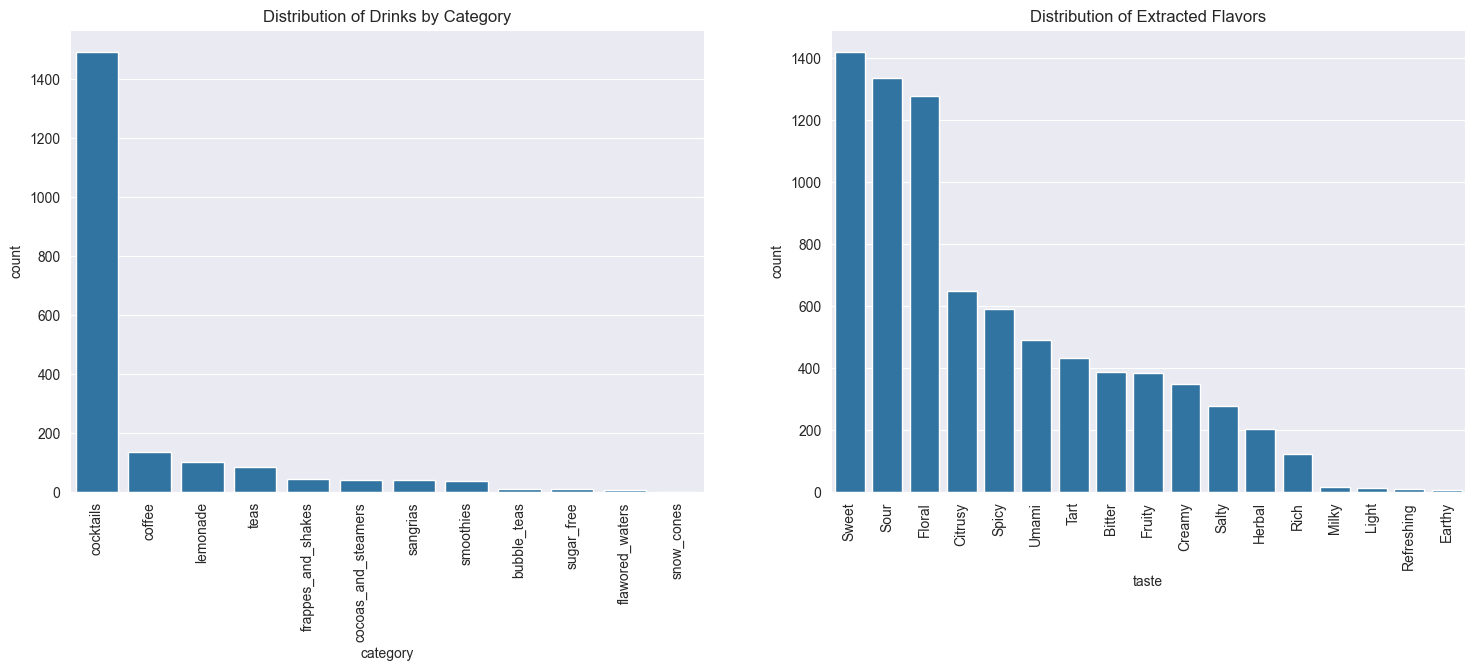

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(data=df, x='category', order=df['category'].value_counts().index, ax=axs[0])
axs[0].set_title('Distribution of Drinks by Category')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

# plot flavor distribution
sns.countplot(data=df_exploded, x='taste', order=df_exploded['taste'].value_counts().index, ax=axs[1])
axs[1].set_title('Distribution of Extracted Flavors')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
plt.show()


The category distribution is skewed, with 'cocktails' being much more represented than other categories. The flavor distribution is also skewed, with 'Sweet', 'Sour', and 'FLoral' being the most common flavors, although not as skewed as the category distribution.

### Category vs. Flavor

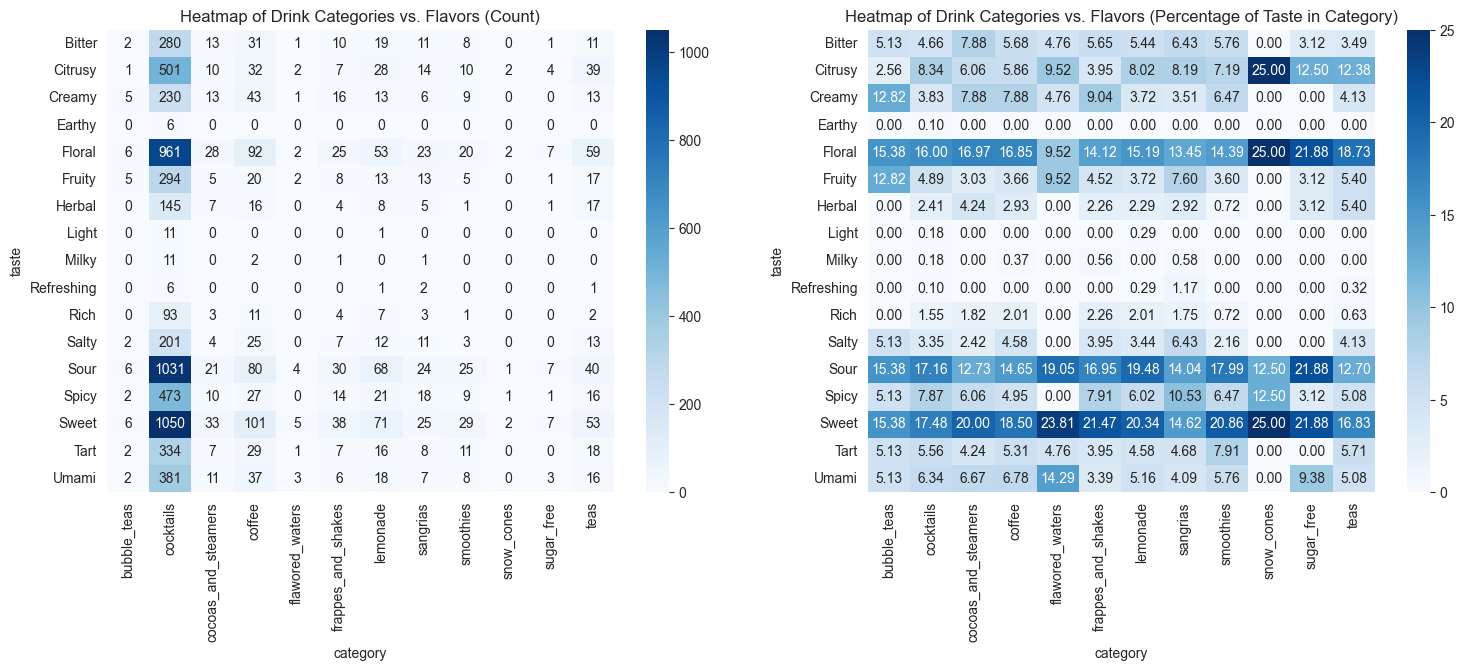

In [24]:
pivot = df_exploded.pivot_table(index='taste', columns='category', aggfunc='size', fill_value=0)
pivot_percentage = pivot.div(pivot.sum(axis=0), axis=1) * 100

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Heatmap of Drink Categories vs. Flavors (Count)')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

sns.heatmap(pivot_percentage, annot=True, fmt='.2f', cmap='Blues', ax=axs[1])
axs[1].set_title('Heatmap of Drink Categories vs. Flavors (Percentage of Taste in Category)')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
plt.show()


We can see, that some flavors are being picked for all categories more often, such as 'Sweet', 'Sour', 'Floral', while some are continuosely being choosed less often, such as 'Light', 'Milky' and 'Refreshing'. We can also notice, that some categories have a flavor that is being picked more often than in other categories, such as 'Sour' in 'sugar free' category, 'Sweet', 'Floral' and 'Citrusy' for 'snow_cones', and 'Creamy' for 'bubble_teas'.

### Distribution of quantity of extracted flavors

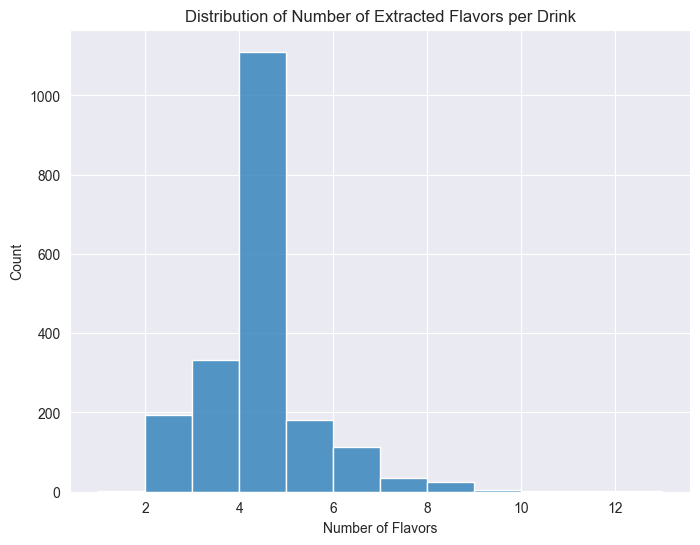

In [25]:
# Calculate number of flavors per drink
df['num_tastes'] = df['taste'].apply(lambda x: len(x) if isinstance(x, list) else 0)

plt.figure(figsize=(8, 6))
sns.histplot(df['num_tastes'], bins=range(1, df['num_tastes'].max()+2), kde=False)
plt.title('Distribution of Number of Extracted Flavors per Drink')
plt.xlabel('Number of Flavors')
plt.ylabel('Count')
plt.show()


The distribution seems to be close to normal, with most drinks having around 4-5 flavors extracted.

### t-SNE Visualization of Embeddings

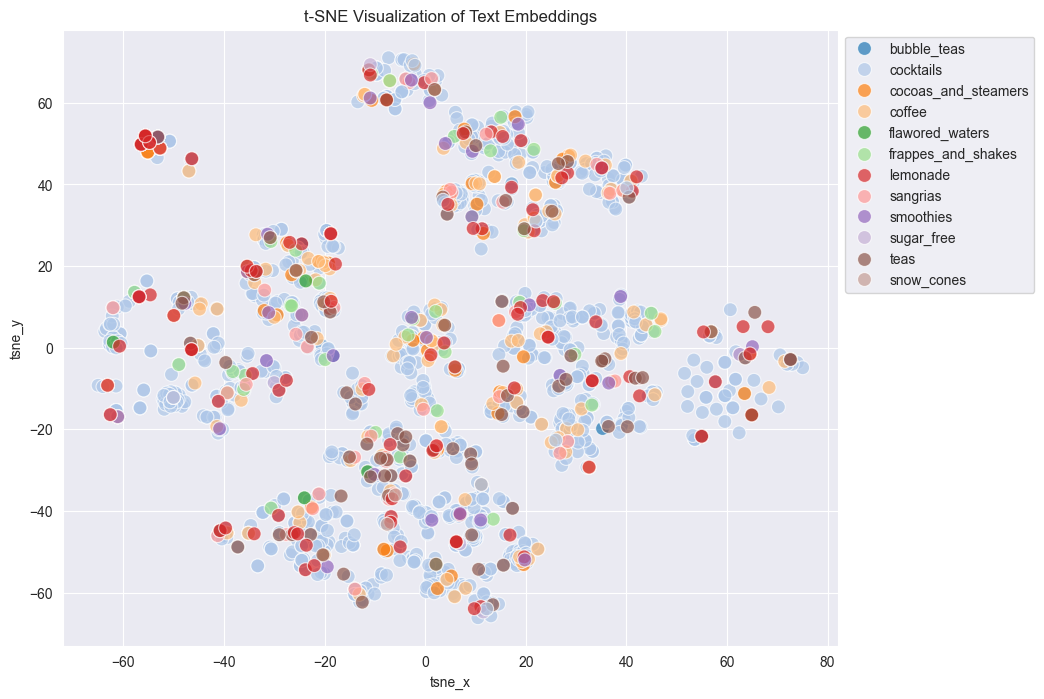

In [26]:
from sklearn.manifold import TSNE
import numpy as np

embeds = np.array(list(df['text_embeds']))

tsne = TSNE(n_components=2, random_state=52)
tsne_results = tsne.fit_transform(embeds)

df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='category', data=df, palette="tab20", s=100, alpha=0.7)
plt.title('t-SNE Visualization of Text Embeddings')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


Text embeddings seem to have some clusters, although they do not correlate with category. This may indicate that ingredients and process of preparation may be the same for different categories, and it is important to investigate these clusters further.

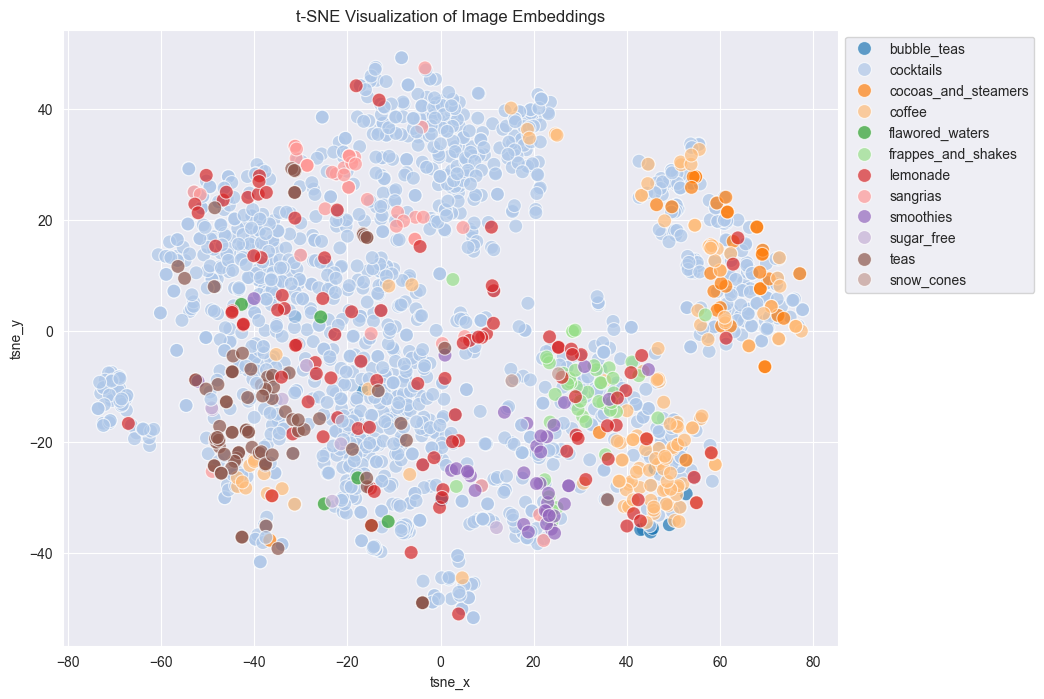

In [27]:
# now the same for image embeddings and combined embeddings
# Convert embedding list to array
embeds = np.array(list(df['image_embeds']))  # or use 'combined_embeds' if you concatenated

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)

# Store t-SNE results in the dataframe
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='category', data=df, palette="tab20", s=100, alpha=0.7)
plt.title('t-SNE Visualization of Image Embeddings')

plt.legend(bbox_to_anchor=(1, 1))
plt.show()


The clusters of image embeddings seem to be even more broad. This may indicate that the images are not very informative for analysing the taste of the drink, or the embeddings are not working greatly for the image data. Further, it is important to check other more advanced methods for visualizing image embeddings, such as t-SimCNE.
But, interestingly, some categories have a clear cluster, such as 'coffe', 'smoothies' and 'teas'. This may indicate that these categories have a clear visual representation that is different from other categories.

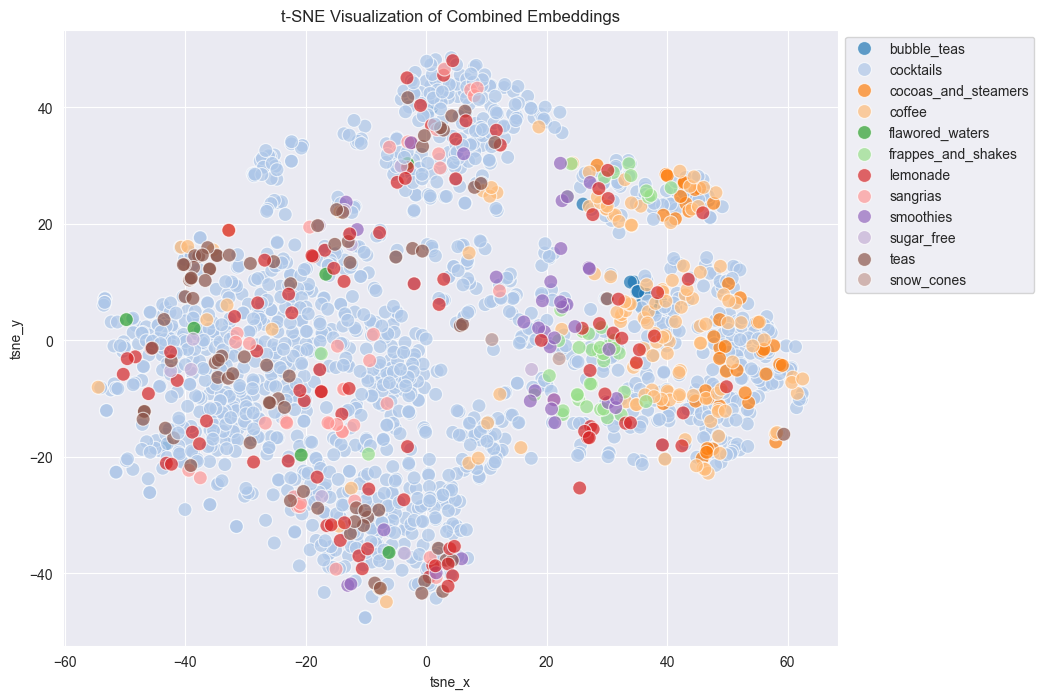

In [28]:
# Convert embedding list to array
embeds = np.array(list(df['combined_embeds']))  # or use 'combined_embeds' if

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)

# Store t-SNE results in the dataframe
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='category', data=df, palette="tab20", s=100, alpha=0.7)
plt.title('t-SNE Visualization of Combined Embeddings')

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Combined embeddings seem to have properties of both text and image embeddings, but the clusters are not as clear as in the text embeddings. This may indicate that the text embeddings are more informative for the task of analyzing the taste of the drink, but we still may need to investigate the combined embeddings further.

### Analyzing ingredients and recipes

In [29]:
import re
import pandas as pd

measurement_units = ['mL', 'L', 'g', 'kg', 'tsp', 'tbsp', 'cup', 'oz']

def is_ingredient(item):
    pattern = r'\d+\s*(' + '|'.join(measurement_units) + r')'
    return re.search(pattern, item, re.IGNORECASE) is not None

def split_recipe(recipe_list):
    ingredients = []
    steps = []
    for item in recipe_list:
        if is_ingredient(item):
            ingredients.append(item)
        else:
            steps.append(item)
    return pd.Series([ingredients, steps])


df[['ingredients', 'steps']] = df['recipie'].apply(split_recipe)

df[['ingredients', 'steps', 'recipie']].head()


,ingredients,steps,recipie
0,"[30 mL Monin Hawaiian Island Syrup, 150 mL tea...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Hawaiian Island Syrup, 150 mL tea..."
1,"[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL..."
2,"[30 mL Monin Strawberry Purée, 15 mL fresh lem...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Strawberry Purée, 15 mL fresh lem..."
3,"[30 mL Monin Chai Tea Concentrate, 210 mL milk...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Chai Tea Concentrate, 210 mL milk..."
4,"[30 mL Monin Golden Turmeric Syrup, 120 mL bla...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Golden Turmeric Syrup, 120 mL bla..."


In [30]:
def split_recipe_ingredients(recipe_list):
    ingredients = []
    for item in recipe_list:
        if is_ingredient(item):
            pattern = r'(\d+(\s+\d+\/\d+)?\s*(' + '|'.join(measurement_units) + r'))'
            ingredients.append(re.sub(pattern, '', item).strip())
    return ingredients
df['ingredients_no_units'] = df['ingredients'].apply(split_recipe_ingredients)
df[['ingredients_no_units', 'ingredients']].head()

,ingredients_no_units,ingredients
0,"[Monin Hawaiian Island Syrup, tea, club soda, ...","[30 mL Monin Hawaiian Island Syrup, 150 mL tea..."
1,"[Monin Lavender Syrup, tea, milk, tapioca bobas]","[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL..."
2,"[Monin Strawberry Purée, fresh lemon juice, te...","[30 mL Monin Strawberry Purée, 15 mL fresh lem..."
3,"[Monin Chai Tea Concentrate, milk, tapioca bobas]","[30 mL Monin Chai Tea Concentrate, 210 mL milk..."
4,"[Monin Golden Turmeric Syrup, black tea, milk,...","[30 mL Monin Golden Turmeric Syrup, 120 mL bla..."


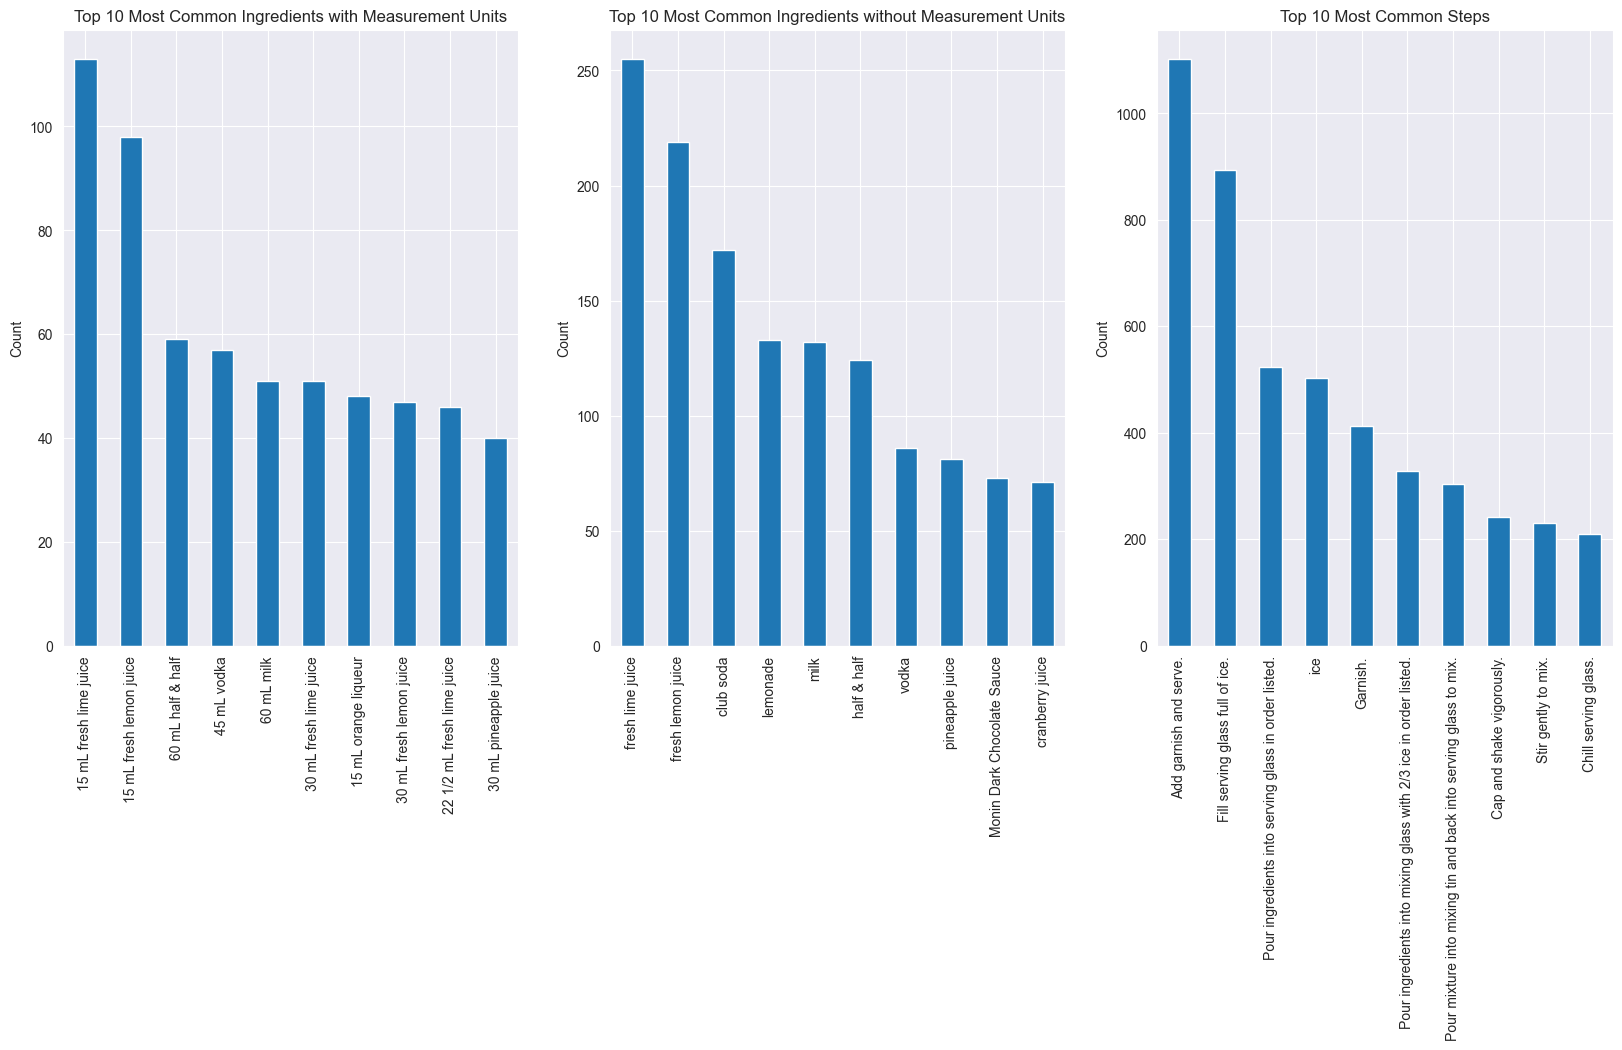

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

all_ingredients = [item for sublist in df['ingredients'] for item in sublist]
ingredient_counts = pd.Series(all_ingredients).value_counts()
ingredient_counts.head(10).plot(kind='bar', ax=axs[0])
axs[0].set_title('Top 10 Most Common Ingredients with Measurement Units')
axs[0].set_ylabel('Count')

all_ingredients_no_units = [item for sublist in df['ingredients_no_units'] for item in sublist]
ingredient_counts_no_units = pd.Series(all_ingredients_no_units).value_counts()
ingredient_counts_no_units.head(10).plot(kind='bar', ax=axs[1])
axs[1].set_title('Top 10 Most Common Ingredients without Measurement Units')
axs[1].set_ylabel('Count')

all_steps = [item for sublist in df['steps'] for item in sublist]
step_counts = pd.Series(all_steps).value_counts()
step_counts.head(10).plot(kind='bar', ax=axs[2])
axs[2].set_title('Top 10 Most Common Steps')
axs[2].set_ylabel('Count')

plt.show()

In [32]:
print("Top 10 Most Common Ingredients with Measurement Units")
print(ingredient_counts.head(20))

print("\nTop 10 Most Common Ingredients without Measurement Units")
print(ingredient_counts_no_units.head(20))

print("\nTop 10 Most Common Steps")
print(step_counts.head(20))


Top 10 Most Common Ingredients with Measurement Units
15 mL fresh lime juice              113
15 mL fresh lemon juice              98
60 mL half & half                    59
45 mL vodka                          57
60 mL milk                           51
30 mL fresh lime juice               51
15 mL orange liqueur                 48
30 mL fresh lemon juice              47
22 1/2 mL fresh lime juice           46
30 mL pineapple juice                40
45 mL silver tequila                 40
15 mL Monin Dark Chocolate Sauce     40
22 1/2 mL fresh lemon juice          35
210 mL lemonade                      33
180 mL club soda                     33
30 mL half & half                    32
60 mL club soda                      29
60 mL cranberry juice                26
45 mL gin                            25
210 mL fresh brewed tea              25
Name: count, dtype: int64

Top 10 Most Common Ingredients without Measurement Units
fresh lime juice               255
fresh lemon juice          

In [33]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### Co-occurrence network of ingredients
To explore the relationships between ingredients, we can build a co-occurrence network where nodes represent ingredients and edges represent how often they appear together in the same recipe.
Edge will be built between two ingredients, if they appear in the dataset together for at least 5 times, and thickness of the edge will represent the number of times they appear together.
The size of the node depends on the degree of the node.

Then, we can use the Louvain community detection algorithm to identify groups of ingredients that are more connected to each other than to the rest of the network. Then, these communities can be visualized using different colors.

In [34]:
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import community.community_louvain as community_louvain

# Build or load co-occurrence graph G
co_occurrence = defaultdict(int)
for ingredients_list in df['ingredients_no_units']:
    unique_ingredients = list(set(ingredients_list))
    for i in range(len(unique_ingredients)):
        for j in range(i + 1, len(unique_ingredients)):
            pair = tuple(sorted([unique_ingredients[i], unique_ingredients[j]]))
            co_occurrence[pair] += 1

co_df = pd.DataFrame([
    {'ingredient1': pair[0], 'ingredient2': pair[1], 'count': count}
    for pair, count in co_occurrence.items()
])

threshold = 5
co_df_filtered = co_df[co_df['count'] >= threshold]

G = nx.Graph()
for _, row in co_df_filtered.iterrows():
    ing1, ing2, weight = row['ingredient1'], row['ingredient2'], row['count']
    G.add_edge(ing1, ing2, weight=weight)

# Compute community partition
partition = community_louvain.best_partition(G)

# compute node sizes based on degree or frequency
degrees = dict(G.degree())
node_sizes = {node: degrees[node] * 5 for node in G.nodes()}  # smaller multiplier for PyVis

# Build PyVis Network
net = Network(
    height="2000px",
    width="100%",
    bgcolor="#222222",   # background color
    font_color="white"
)

net.force_atlas_2based()

import random
import colorsys

num_communities = len(set(partition.values()))
# Generate random distinct colors
def random_color():
    h, s, v = random.random(), 0.6 + random.random()*0.4, 0.9
    r, g, b = [int(256*i) for i in colorsys.hsv_to_rgb(h, s, v)]
    return f'rgb({r},{g},{b})'

community_colors = {c: random_color() for c in set(partition.values())}

for node in G.nodes():
    comm = partition[node]
    net.add_node(
        n_id=node,
        label=node,
        size=node_sizes[node],
        color=community_colors[comm]
    )

for u, v, data in G.edges(data=True):
    net.add_edge(u, v, value=data['weight'])

net.show("co_occurrence.html", notebook=False)


co_occurrence.html


The graph can be seen at: [co_occurrence.html](co_occurrence.html).

We can notice, that most versatile ingredients are 'fresh lemon juice', 'fresh lime juice', 'club soda', 'half & half' and 'milk'. These ingredients are used in a lot of recipes and are connected to a lot of other ingredients.
Additionally, they form 3 major communities:
1. Ingredients for 'milky' drinks (with centers in 'milk', 'half & half')
2. Ingredients that appear with lime juice
3. Ingredients that appear with lemon juice and club soda
Although last two communities also have a lot in common, there are still a lot of ingredients that are unique to each community.

### Extracting Common Action Verbs

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


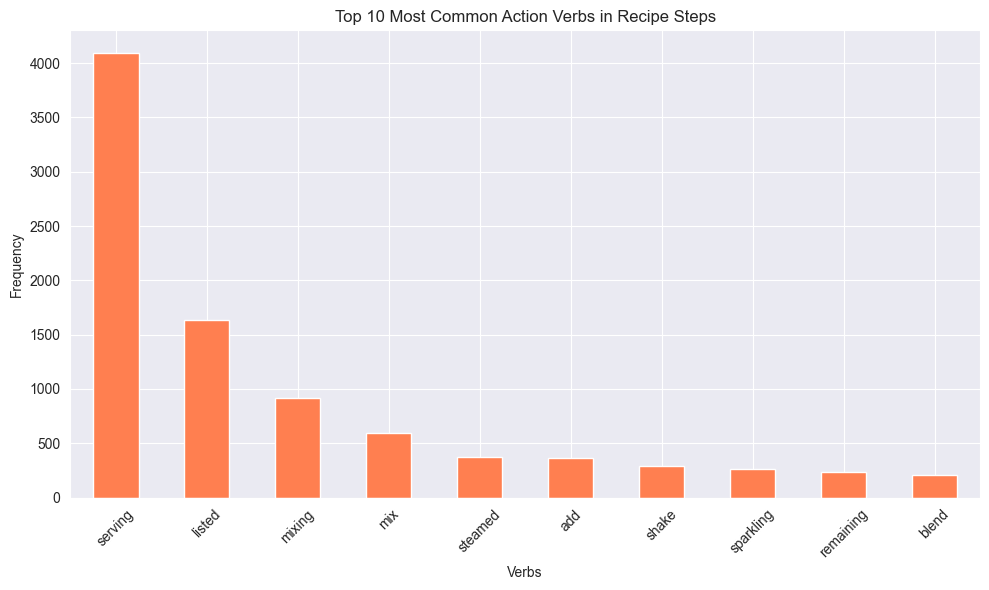

In [35]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def extract_verbs(text):
    # Tokenize and tag part-of-speech
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    # Extract verbs (tags that start with 'VB')
    verbs = [word.lower() for word, tag in tagged if tag.startswith('VB')]
    return verbs

all_verbs = []
for steps in df['steps']:
    for step in steps:
        all_verbs.extend(extract_verbs(step))
        
verb_counts = pd.Series(all_verbs).value_counts()

plt.figure(figsize=(10, 6))
verb_counts.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Most Common Action Verbs in Recipe Steps')
plt.ylabel('Frequency')
plt.xlabel('Verbs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Initial clustering of recipes based on embeddings

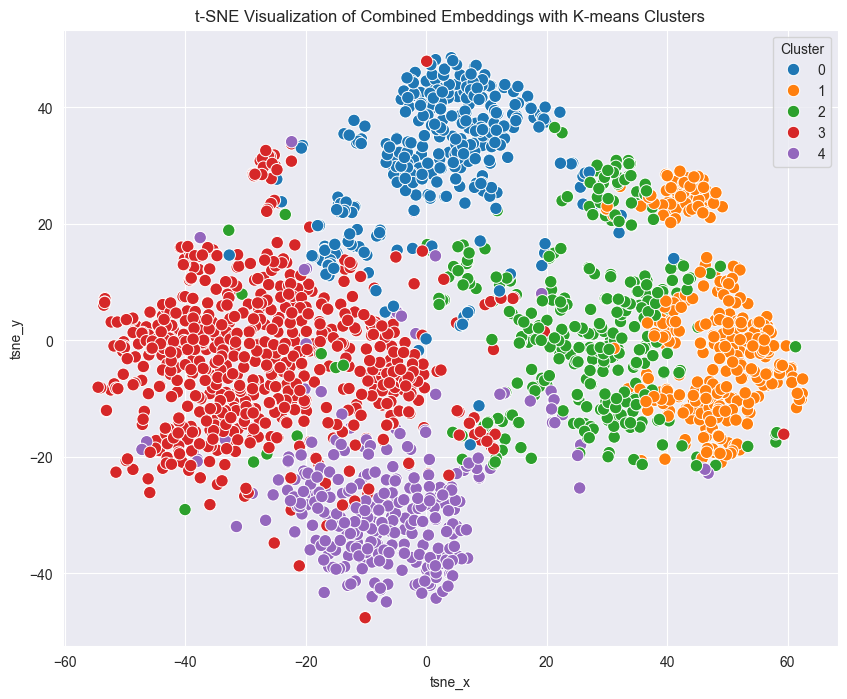

In [36]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

embeds = np.array(list(df['combined_embeds']))

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeds)
df['cluster'] = clusters

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='cluster', data=df, palette='tab10', s=80)
plt.title('t-SNE Visualization of Combined Embeddings with K-means Clusters')
plt.legend(title='Cluster')
plt.show()


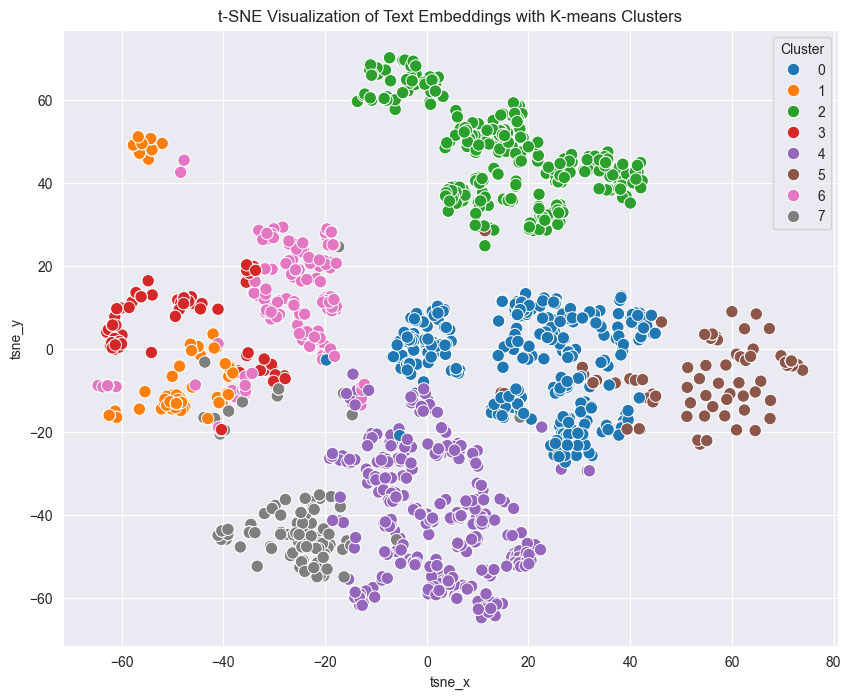

In [37]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

embeds = np.array(list(df['text_embeds']))

kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(embeds)
df['cluster'] = clusters

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='cluster', data=df, palette='tab10', s=80)
plt.title('t-SNE Visualization of Text Embeddings with K-means Clusters')
plt.legend(title='Cluster')
plt.show()

#### Save the dataframe

In [38]:
df.head()

,_id,name,recipie,category,image_url,drink_url,taste,text_embeds,image_embeds,combined_embeds,num_tastes,tsne_x,tsne_y,ingredients,steps,ingredients_no_units,cluster
0,67cdeca2d61baaa7449cc9f0,Hawaiian Pearl Bubble Tea,"[30 mL Monin Hawaiian Island Syrup, 150 mL tea...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/hawaiian-pearl-bubbl...,"[Citrusy, Sour]","[-0.24252538, -0.03239031, -0.033222646, -0.16...","[-0.27175665, 0.78657407, -0.12571463, 0.28179...","[-0.24252538, -0.03239031, -0.033222646, -0.16...",2,-39.105148,-44.789482,"[30 mL Monin Hawaiian Island Syrup, 150 mL tea...","[Fill serving glass full of ice., Pour ingredi...","[Monin Hawaiian Island Syrup, tea, club soda, ...",7
1,67cdeca4d61baaa7449cc9f1,Blue Bubble Milk Tea,"[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/blue-bubble-milk-tea,"[Floral, Salty, Sweet]","[-0.14095394, -0.083773464, 0.11836207, 0.1184...","[0.13253294, 0.3377095, -0.1990263, 0.43868613...","[-0.14095394, -0.083773464, 0.11836207, 0.1184...",3,32.690060,-8.182166,"[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL...","[Fill serving glass full of ice., Pour ingredi...","[Monin Lavender Syrup, tea, milk, tapioca bobas]",5
2,67cdeca6d61baaa7449cc9f2,Strawberry Bubble Burst Tea,"[30 mL Monin Strawberry Purée, 15 mL fresh lem...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/strawberry-bubble-bu...,"[Fruity, Floral, Sweet, Bitter]","[-0.15835342, 0.0019426532, 0.3578596, -0.0975...","[-0.2511133, 0.81496274, -0.2903915, -0.023840...","[-0.15835342, 0.0019426532, 0.3578596, -0.0975...",4,17.568716,40.455109,"[30 mL Monin Strawberry Purée, 15 mL fresh lem...","[Fill serving glass full of ice., Pour ingredi...","[Monin Strawberry Purée, fresh lemon juice, te...",2
3,67cdeca8d61baaa7449cc9f3,Bubble Chai Tea,"[30 mL Monin Chai Tea Concentrate, 210 mL milk...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/bubble-chai-tea,"[Sweet, Creamy]","[-0.12927054, -0.08475506, 0.08285433, 0.07675...","[0.051974114, 0.3284219, -0.1577228, 0.3664531...","[-0.12927054, -0.08475506, 0.08285433, 0.07675...",2,-19.616926,28.907650,"[30 mL Monin Chai Tea Concentrate, 210 mL milk...","[Fill serving glass full of ice., Pour ingredi...","[Monin Chai Tea Concentrate, milk, tapioca bobas]",6
4,67cdecabd61baaa7449cc9f4,Golden Jelly Bubble Tea,"[30 mL Monin Golden Turmeric Syrup, 120 mL bla...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/golden-jelly-bubble-tea,"[Floral, Salty, Bitter, Floral]","[-0.21029785, -0.07430075, 0.36528605, 0.13653...","[-0.3368239, 0.99112916, -0.21998006, 0.319091...","[-0.21029785, -0.07430075, 0.36528605, 0.13653...",4,20.613155,29.475266,"[30 mL Monin Golden Turmeric Syrup, 120 mL bla...","[Fill serving glass full of ice., Pour ingredi...","[Monin Golden Turmeric Syrup, black tea, milk,...",2


In [39]:
df.to_csv('../data/drinks.csv', index=False)

# Analyzing clusters
We need to analyze statistics of each cluster, such as:
- number of drinks
- number of unique flavors
- flavor distribution and which flavors are most common

We need info about the cluster to be able to name the cluster and understand what is the main difference between clusters.

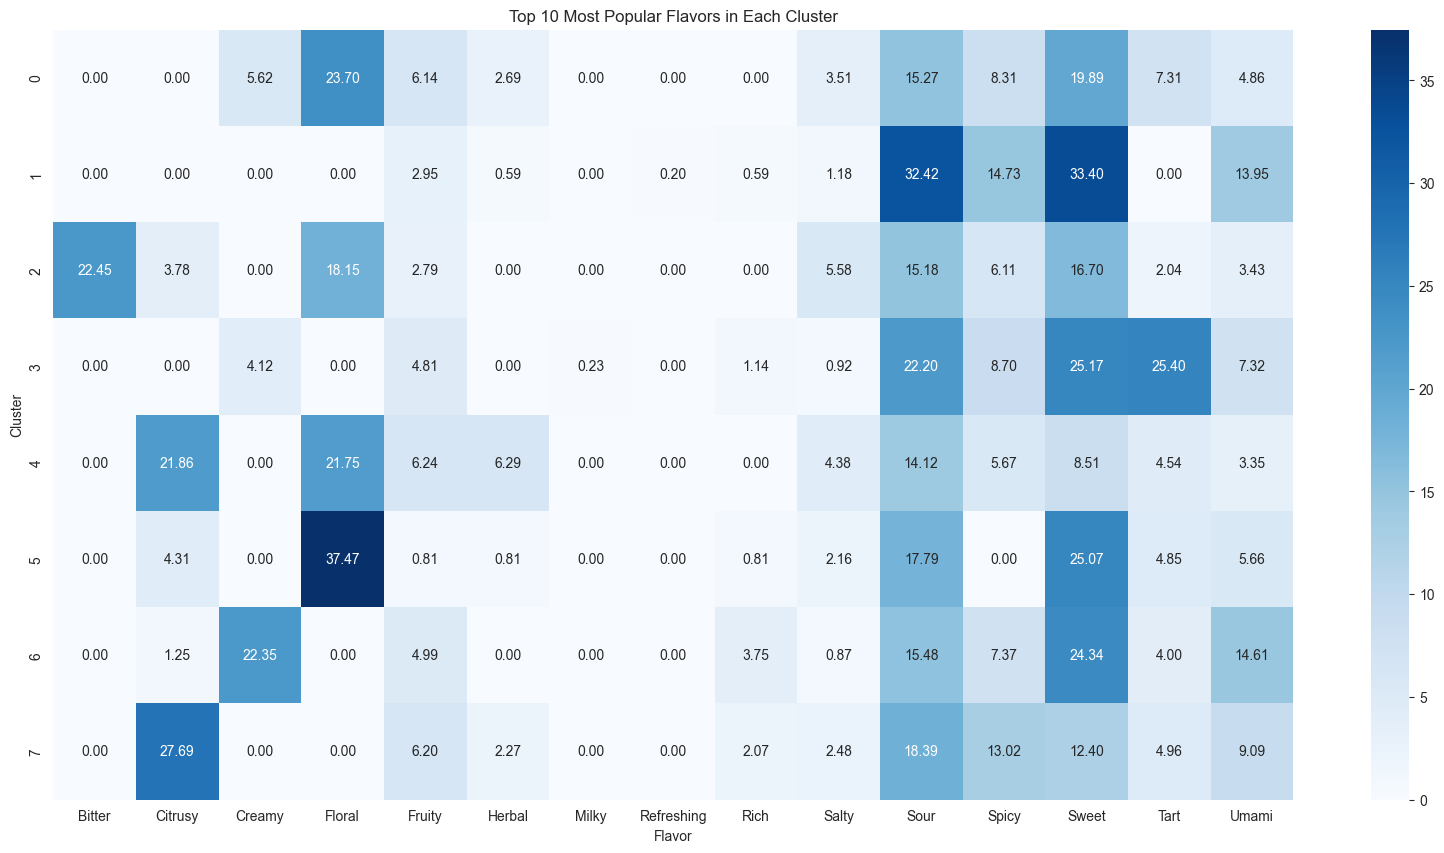

In [54]:
# calculate top 10 most popular flavors in each cluster and percentage of flavors in each cluster
# group by cluster and explode the taste column
df_exploded = df.explode('taste')
df_exploded['taste'].value_counts()
# group by cluster and taste and count the number of drinks
cluster_taste_counts = df_exploded.groupby(['cluster', 'taste']).size().reset_index(name='count')
# calculate percentage of each flavor in each cluster
cluster_taste_counts['percentage'] = cluster_taste_counts.groupby('cluster')['count'].transform(lambda x: x / x.sum() * 100)
# calculate top 10 most popular flavors in each cluster
cluster_taste_counts_top10 = cluster_taste_counts.sort_values(['cluster', 'count'], ascending=[True, False]).groupby('cluster').head(10)
# pivot the table to have flavors as columns
cluster_taste_counts_pivot = cluster_taste_counts_top10.pivot(index='cluster', columns='taste', values='percentage').fillna(0)
# plot the top 10 most popular flavors in each cluster
plt.figure(figsize=(20, 10))
sns.heatmap(cluster_taste_counts_pivot, annot=True, fmt='.2f', cmap='Blues')
plt.title('Top 10 Most Popular Flavors in Each Cluster')
plt.xlabel('Flavor')
plt.ylabel('Cluster')
plt.show()

In [56]:
# print top 3 flavors in each cluster with print
for i in range(cluster_taste_counts_pivot.shape[0]):
    print(f"Cluster {i}:")
    print(cluster_taste_counts_pivot.iloc[i].sort_values(ascending=False).head(5))
    print()

Cluster 0:
taste
Floral    23.698069
Sweet     19.894675
Sour      15.272089
Spicy      8.308953
Tart       7.314219
Name: 0, dtype: float64

Cluster 1:
taste
Sweet     33.398821
Sour      32.416503
Spicy     14.734774
Umami     13.948919
Fruity     2.946955
Name: 1, dtype: float64

Cluster 2:
taste
Bitter    22.454916
Floral    18.150087
Sweet     16.695753
Sour      15.183246
Spicy      6.108202
Name: 2, dtype: float64

Cluster 3:
taste
Tart     25.400458
Sweet    25.171625
Sour     22.196796
Spicy     8.695652
Umami     7.322654
Name: 3, dtype: float64

Cluster 4:
taste
Citrusy    21.855670
Floral     21.752577
Sour       14.123711
Sweet       8.505155
Herbal      6.288660
Name: 4, dtype: float64

Cluster 5:
taste
Floral    37.466307
Sweet     25.067385
Sour      17.789757
Umami      5.660377
Tart       4.851752
Name: 5, dtype: float64

Cluster 6:
taste
Sweet     24.344569
Creamy    22.347066
Sour      15.480649
Umami     14.606742
Spicy      7.365793
Name: 6, dtype: float64

Cluste

0 - 'FLoral', 'Sweet', 'Sour'\
1 - 'Sweet', 'Sour', 'Spicy', 'Umami'\
2 - 'Bitter', 'Floral', 'Sweet', 'Sour'\
3 - 'Tart', 'Sweet', 'Sour'\
4 - 'Citrusy', 'FLoral', 'Sour'\
5 - 'Floral', 'Sweet', 'Sour'\
6 - 'Sweet', 'Creamy', 'Sour', 'Umami'\
7 - 'Citrusy', 'Sour', 'Spicy', 'Sweet'\